In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import socket
import importlib
import os
import sys
#BASE_DIR = os.path.dirname(os.path.abspath(__file__))
#sys.path.append(BASE_DIR)
from pointnetvlad_eval import *
from sklearn.neighbors import NearestNeighbors, KDTree


In [3]:
QUERY_PATH = 'pointnetvlad_submaps/'

RESULTS_FOLDER="testing_results/pointnetvlad/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   

# One-time partial release case: Spatial inference using pointnetvlad

In [4]:
pickle_file = 'partial_results.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No pickle file yet:",pickle_file)
    results_pickle = []
    
for radius in np.arange(0.25,3.1,0.25):
    
    query_fol = 'ransac_partial_radius_'+str(radius)+"_4096_unassisted"#
    
    QUERY_FILE = 'pointnetvlad_submaps/3d_{}_evaluation_query.pickle'.format(query_fol)
    
    output_file = RESULTS_FOLDER +pickle_file+query_fol+'.txt'
    
    QUERY_SETS= get_sets_dict(QUERY_FILE)

    query_partial_path = os.path.join(QUERY_PATH,query_fol)

    df_test= pd.read_csv(os.path.join(query_partial_path,"pointcloud_centroids_4m.csv"),sep=',')
    
    QUERY_DATABASE_NUMPY = np.asarray(df_test)
    
    print("Doing",QUERY_FILE,query_partial_path)
    
    ave_recall, ave_intra_dist = evaluate(QUERY_SETS, QUERY_DATABASE_NUMPY, output_file)
    
    results_pickle.append([
            radius,
            ave_recall,
            ave_intra_dist
        ])

    with open(RESULTS_FOLDER + pickle_file,'wb') as pickle_output:
        pickle.dump(results_pickle,pickle_output)

    

Trajectories Loaded.
Doing pointnetvlad_submaps/3d_ransac_partial_radius_0.25_4096_unassisted_evaluation_query.pickle pointnetvlad_submaps/ransac_partial_radius_0.25_4096_unassisted
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(27912, 256)
(990, 256)
0 0 Database output: (27912, 256) Queries output: (990, 256)
 Average Inter-space Error: 0.8555555555555556
 Ave Intra-space Distance Error: 1.1303804335768661
 Average similarity: 0.9573012
Trajectories Loaded.
Doing pointnetvlad_submaps/3d_ransac_partial_radius_0.5_4096_unassisted_evaluation_query.pickle pointnetvlad_submaps/ransac_partial_radius_0.5_4096_unassisted
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Mo

# Results: One-time release case with pointnetVLAD (vs NN-matcher)

In [23]:
pickle_file = 'partial_results.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad = []

for radius, recall, intra_dist in results_pickle:
    pointnetvlad.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
pointnetvlad = np.asarray(pointnetvlad)

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials = pickle.load(f)

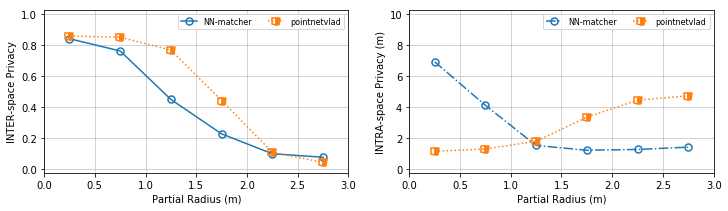

In [24]:
fig=plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Partial Radius (m)")

markersize = 7
linewidth = 1.5

RansacNN = np.asarray(results_partials[1])

ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-o",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher"
)

ax1.plot(
    pointnetvlad[::2,0],
    pointnetvlad[::2,1],
    ":s",
    linewidth = linewidth,fillstyle = 'right',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad"
)

ax1.legend(loc = "upper right", ncol = 2, fontsize = 8);

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)")
ax2.set_xlabel("Partial Radius (m)")

ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.o',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher"
)

ax2.plot(
    pointnetvlad[::2,0],
    pointnetvlad[::2,2],
    ":s",
    linewidth = linewidth,fillstyle = 'right',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad"
)

ax2.legend(loc = "upper right", ncol = 2, fontsize = 8);

plt.savefig('plot/partials-radius-pointnetvlad-jittered.png', format='png', dpi=300,bbox_inches = 'tight')


# Successive case: spatial inference using pointnetvlad

In [15]:
for radius in np.arange(0.5,2.1,0.5):
    
    pickle_file = 'successive_results_'+str(radius)+'_new.pickle'

    try:
        with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
            results_pickle = pickle.load(pickle_output)
    except:
        print("No "+pickle_file+" file yet.")
        results_pickle = []

    successive_path = 'successive_radius_'+str(radius)
    
    for release in np.arange(1,100,5):

        query_fol = 'release_'+str(release)

        QUERY_FILE = 'pointnetvlad_submaps/successive_queries/3d_jittered_{}_evaluation_query.pickle'.format(successive_path+"_"+query_fol)

        output_file = RESULTS_FOLDER +pickle_file+query_fol+'.txt'

        QUERY_SETS= get_sets_dict(QUERY_FILE)

        query_partial_path = os.path.join(QUERY_PATH,successive_path,query_fol)

        df_test= pd.read_csv(os.path.join(query_partial_path,"pointcloud_centroids_4m.csv"),sep=',')

        QUERY_DATABASE_NUMPY = np.asarray(df_test)

        print("Doing",QUERY_FILE,query_partial_path)

        ave_recall, ave_intra_dist = evaluate(QUERY_SETS, QUERY_DATABASE_NUMPY, output_file)

        results_pickle.append([
                release,
                ave_recall,
                ave_intra_dist
            ])

        with open(RESULTS_FOLDER + pickle_file,'wb') as pickle_output:
            pickle.dump(results_pickle,pickle_output)
    


No successive_results_0.5_new.pickle file yet.
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_0.5_release_1_evaluation_query.pickle pointnetvlad_submaps/successive_radius_0.5/release_1
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(226, 256)
0 0 Database output: (27912, 256) Queries output: (226, 256)
 Average Inter-space Error: 0.8407079646017699
 Ave Intra-space Distance Error: 1.614335179331336
 Average similarity: 0.82068896
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_0.5_release_6_evaluation_query.pickle pointnetvlad_submaps/successive_radius_0.5/release_6
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(166, 256)


Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(148, 256)
0 0 Database output: (27912, 256) Queries output: (148, 256)
 Average Inter-space Error: 0.277027027027027
 Ave Intra-space Distance Error: 3.97877557452567
 Average similarity: 0.96395886
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_0.5_release_76_evaluation_query.pickle pointnetvlad_submaps/successive_radius_0.5/release_76
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(164, 256)
0 0 Database output: (27912, 256) Queries output: (164, 256)
 Average Inter-space Error: 0.2621951219512195
 Ave Intra-space Distance Error: 3.992622398851031
 Average similarity: 0.9528381
Trajectories Loaded.
Doing pointnetvlad_subma

Model restored.
(169, 256)
0 0 Database output: (27912, 256) Queries output: (169, 256)
 Average Inter-space Error: 0.11834319526627224
 Ave Intra-space Distance Error: 4.554478309953561
 Average similarity: 0.9765256
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.0_release_46_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.0/release_46
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(188, 256)
0 0 Database output: (27912, 256) Queries output: (188, 256)
 Average Inter-space Error: 0.11702127659574468
 Ave Intra-space Distance Error: 4.4567466149330235
 Average similarity: 0.9710793
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.0_release_51_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.0/release_51
Tensor("query_tri

Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(154, 256)
0 0 Database output: (27912, 256) Queries output: (154, 256)
 Average Inter-space Error: 0.18181818181818166
 Ave Intra-space Distance Error: 4.02639090726786
 Average similarity: 0.97009915
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.5_release_21_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.5/release_21
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(154, 256)
0 0 Database output: (27912, 256) Queries output: (154, 256)
 Average Inter-space Error: 0.14935064935064923
 Ave Intra-space Distance Error: 4.388290493858616
 Average similarity: 0.97276574
Trajectories Loaded.
Doing pointnetvlad_s

Model restored.
(152, 256)
0 0 Database output: (27912, 256) Queries output: (152, 256)
 Average Inter-space Error: 0.07894736842105254
 Ave Intra-space Distance Error: 4.671623508592007
 Average similarity: 0.9758181
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.5_release_91_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.5/release_91
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(153, 256)
0 0 Database output: (27912, 256) Queries output: (153, 256)
 Average Inter-space Error: 0.07189542483660127
 Ave Intra-space Distance Error: 4.678144628844128
 Average similarity: 0.9796216
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.5_release_96_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.5/release_96
Tensor("query_trip

Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(148, 256)
0 0 Database output: (27912, 256) Queries output: (148, 256)
 Average Inter-space Error: 0.07432432432432434
 Ave Intra-space Distance Error: 4.906753908308414
 Average similarity: 0.98389405
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_2.0_release_66_evaluation_query.pickle pointnetvlad_submaps/successive_radius_2.0/release_66
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
(157, 256)
0 0 Database output: (27912, 256) Queries output: (157, 256)
 Average Inter-space Error: 0.12101910828025475
 Ave Intra-space Distance Error: 4.561224713646803
 Average similarity: 0.9755439
Trajectories Loaded.
Doing pointnetvlad_s

# Results: Successive case with pointnetVLAD (vs NN-matcher)

In [16]:
pointnetvlad_successive = []

for radius in np.arange(0.5,2.1,0.5):
    
    pickle_file = 'successive_results_'+str(radius)+'_new.pickle'

    pointnetvlad_successive_per_radius = []

    try:
        with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
            results_pickle = pickle.load(pickle_output)
    except:
        print("No results_ransac.")

    for release, recall, intra_dist in results_pickle:
        pointnetvlad_successive_per_radius.append([
            release,
            recall[0],
            intra_dist[0]
        ])

    pointnetvlad_successive_per_radius = np.asarray(pointnetvlad_successive_per_radius)#[-16:]

    pointnetvlad_successive.append(pointnetvlad_successive_per_radius)
    
with open('testing_results/successive/nn_matcher_errors.pickle', 'rb') as f:
    [succ_NN_errors,succ_NN_intra_errors] = pickle.load(f)

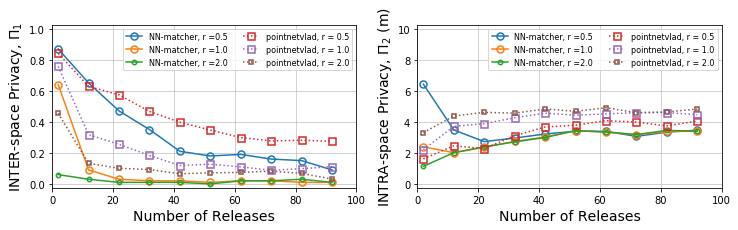

In [25]:
fig=plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,100)
ax1.set_ylabel("INTER-space Privacy, $\Pi_1$", fontsize = 14)
ax1.set_xlabel("Number of Releases", fontsize = 14)

markersize = 7
linewidth = 1.5
#plt.minorticks_on()

for radius, inter_errors in succ_NN_errors:#[:2]:

    if radius == 1.5: continue

    #print(RawNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,100,10)[:len(inter_errors):]+1,
        inter_errors[::], 
        '-o', 
        linewidth = linewidth,fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "NN-matcher, r ="+ str(radius)
    )

for i, radius in enumerate(np.arange(0.5,2.1,0.5)):

    if radius == 1.5: continue

    ax1.plot(
        np.arange(1,100,10)+1,
        pointnetvlad_successive[i][::2,1],
        ":s",
        linewidth = linewidth,fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "pointnetvlad, r = "+str(radius)
    )

ax1.legend(loc = "upper right", ncol = 2, fontsize = 8);

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,100)

ax2.set_ylabel("INTRA-space Privacy, $\Pi_2$ (m)", fontsize = 14)
ax2.set_xlabel("Number of Releases", fontsize = 14)

for radius, intra_errors in succ_NN_intra_errors:#[:2]:
    
    if radius == 1.5: continue
    
    ax2.plot(
        np.arange(1,100,10)+1,#[:len(intra_errors):2]+1,
        intra_errors[::,0], 
        '-o',
        linewidth = linewidth, #capsize = 4.0, 
        #marker = markers[0],
        fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "NN-matcher, r ="+ str(radius)
    )

for i, radius in enumerate(np.arange(0.5,2.1,0.5)):

    if radius == 1.5: continue

    ax2.plot(
        np.arange(1,100,10)+1,
        pointnetvlad_successive[i][::2,2],
        ":s",
        linewidth = linewidth,fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "pointnetvlad, r = "+str(radius)
    )


ax2.legend(loc = "upper right", ncol = 2, fontsize = 8);

plt.savefig('plots/successive-with-pointnetvlad.png', format='png', dpi=300,bbox_inches = 'tight')
